In [1]:
import os
import pickle
import argparse
import numpy as np
from itertools import cycle
from collections import defaultdict
from functools import partial
from typing import List, Dict, Tuple

from qanta.guesser.abstract import AbstractGuesser
from qanta.datasets.quiz_bowl import QuestionDatabase
from qanta.util import constants as c
from qanta.buzzer import constants as bc
from qanta import logging
from qanta.buzzer.util import GUESSERS, load_protobowl
from qanta.reporting.report_generator import ReportGenerator
from qanta.util.multiprocess import _multiprocess

/home/airsplay/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
from qanta.reporting.new_performance import get_his_stats, get_protobowl, _get_top_guesses

In [8]:
all_questions = QuestionDatabase().all_questions()
answers = {k: v.page for k, v in all_questions.items()}
question_texts = {k: v.text for k, v in all_questions.items()}
protobowl_ids = {k: all_questions[k].protobowl 
    for k in all_questions if all_questions[k].protobowl != ''}
protobowl_df = load_protobowl().groupby('qid')

guesses_df_folds = dict()
top_guesses_folds = dict()
for fold in c.BUZZER_GENERATION_FOLDS:
    guesses_df_folds[fold] = AbstractGuesser.load_guesses(
            bc.GUESSES_DIR, folds=[fold])
    questions = guesses_df_folds[fold].groupby('qnum')
    top_guesses_folds[fold] = _multiprocess(_get_top_guesses, questions, 
            info='Top guesses', multi=True)
    top_guesses_folds[fold] = {k: v for k, v in top_guesses_folds[fold]}

[Top guesses] (16) done: 7587/7587
[Top guesses] (16) done: 2089/2089
[Top guesses] (16) done: 1412/1412
[Top guesses] (16) done: 69/69


In [19]:
def plot(fold, model_name):
    questions = guesses_df_folds[fold].groupby('qnum')

    buzzes_dir = bc.BUZZES_DIR.format(fold, model_name)
    with open(buzzes_dir, 'rb') as infile:
        buzzes = pickle.load(infile)
    print('Buzzes loaded from {}.'.format(buzzes_dir))

    inputs = [top_guesses_folds[fold], buzzes, answers, None, fold, None]

    get_his_stats(*inputs)
    p_inputs = [question_texts, protobowl_ids, protobowl_df, questions] + inputs
    stats = get_protobowl(p_inputs)
    for key, value in stats:
        print(key, value)

2017-05-26 02:34:25,471 - qanta.reporting.new_performance - INFO - [buzzerdev] Histogram reporting


Buzzes loaded from output/buzzer/buzzerdev_buzzes_rnn_10.pkl.


[Histogram stats] (16) done: 7575/7587
/home/airsplay/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


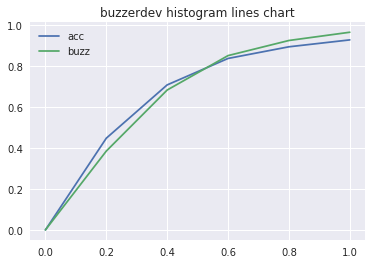

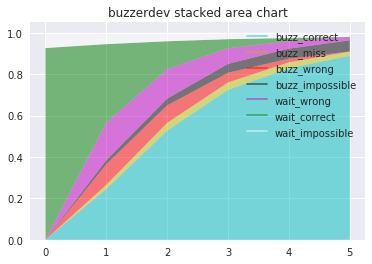

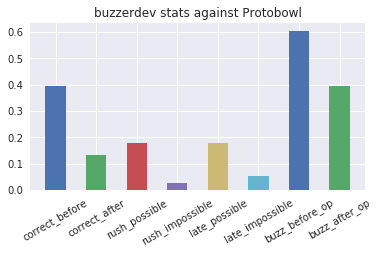

ValueError: too many values to unpack (expected 2)

In [20]:
%matplotlib inline
model_name = 'rnn_10'
fold = 'buzzerdev'
plot(fold, model_name)